In [1]:
INPUT_FILE_NAME = 'log_sample.csv'
#'small_log.csv'
#'log_sample.csv'

In [2]:
import csv
import numpy as np
from tqdm import notebook

In [3]:
class Event:
    def __init__(self, timestamp, group_id, device_id, event_id, event_count):
        self.timestamp = int(timestamp)
        self.group_id = group_id
        self.event_id = event_id
        self.device_id = device_id
        if event_count:
            self.count = int(event_count)
        else:
            self.count = 0

In [4]:
def read_from_file_to_event_list():
    events = []
    with open(INPUT_FILE_NAME, 'r') as fin:
        for row in notebook.tqdm(csv.reader(fin, delimiter=',')):
            if (row[12].split('.')[0]):# and row[5] == 'productivity':
                events.append(Event(row[3], row[5], row[7], row[10], row[12].split('.')[0]))
    return events        
            

In [5]:
events = read_from_file_to_event_list()

In [46]:
import math

In [47]:
def round_half_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n*multiplier + 0.5) / multiplier

In [69]:
def get_action_N_probs(events):
    user_action_to_timestamps = {}
    action_N_to_p = {}
    actions = {}
    user_to_max_timestamp = {}
    user_action_to_max_diff = {}
    for elem in notebook.tqdm(events):
        user = elem.device_id
        group = elem.group_id
        event = elem.event_id
        timestamp = elem.timestamp
        if user in user_to_max_timestamp.keys():
            user_to_max_timestamp[user] = max(user_to_max_timestamp[user], timestamp)
        else:
            user_to_max_timestamp[user] = timestamp
        actions[(group, event)] = True
        if user in user_action_to_timestamps.keys():
            if (group, event) in user_action_to_timestamps[user].keys():
                user_action_to_timestamps[user][(group, event)].append(timestamp)
            else:
                user_action_to_timestamps[user][(group, event)] = [timestamp]
        else:
            user_action_to_timestamps[user] = {}
            user_action_to_timestamps[user][(group, event)] = [timestamp]
    
    maxN = 0
    for user in notebook.tqdm(user_action_to_timestamps.keys()):    
        user_action_to_max_diff[user] = {}
        for action in user_action_to_timestamps[user].keys():
            user_action_to_timestamps[user][action] = sorted(user_action_to_timestamps[user][action])
            #print(user_action_to_timestamps[user][action])
            prev = None
            user_action_to_max_diff[user][action] = 0
            for elem in user_action_to_timestamps[user][action]:
                if prev:
                    maxN = max(maxN, elem - prev)
                    user_action_to_max_diff[user][action] = max(user_action_to_max_diff[user][action], elem - prev)
                prev = elem
            user_action_to_timestamps[user][action].append(user_to_max_timestamp[user])
    maxN = round_half_up(maxN / 1000 / 60 / 60 / 24)
    print(maxN)
    
    for action in notebook.tqdm(actions.keys()):
        action_N_to_p[action] = {}
        for N in range(60, 0, -1):
            #print(N)
            done_after = 0
            total = 0
            for user in user_action_to_timestamps.keys():
                #print(user_action_to_timestamps[user].keys())
                #print(user_action_to_max_diff[user].keys())
                if action in user_action_to_timestamps[user].keys():
                    sorted_timestamps = user_action_to_timestamps[user][action]
                    max_diff = user_action_to_max_diff[user][action]
                    prev = sorted_timestamps[0]
                    first_N = 0
                    maxdiff = 0
                    for i in range(1, len(sorted_timestamps)):
                        elem = sorted_timestamps[i]
                        diff = round_half_up((elem - prev) / 1000 / 60 / 60 / 24)
                        #if diff != 0 :
                            #print(str(diff) + " " + str((elem - prev) / 1000 / 60 / 60 / 24))
                        if diff == N:
                            total += 1
                            if i != len(sorted_timestamps) - 1 or user_action_to_max_diff[user][action] > N:
                                done_after += 1
                        maxdiff = max(maxdiff, diff)
                        prev = elem
            if total != 0:
               # if N < 60:
               #     action_N_to_p[action][N] = max(action_N_to_p[action][N + 1], done_after / total)
               # else:
                    action_N_to_p[action][N] = done_after / total
            else:
                if N < 60:
                    action_N_to_p[action][N] = action_N_to_p[action][N + 1]
                else:
                    action_N_to_p[action][N] =  0
    return action_N_to_p
            

In [70]:
action_N_probs = get_action_N_probs(events)


30.0


In [71]:
np.mean([action_N_probs[i][41] for i in action_N_probs.keys()])

0.0

In [78]:
means = []
for N in range(1, 40):
    means.append(np.mean([action_N_probs[i][N] for i in action_N_probs.keys()]))

In [79]:

import matplotlib.pyplot as plt

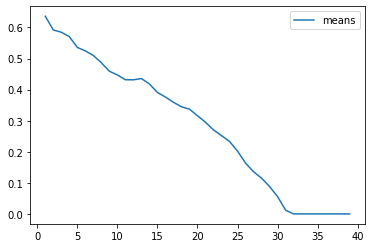

In [80]:
plt.plot(list(range(1, 40)), means, label='means')
plt.legend()
plt.show()

In [ ]:
len(events)

In [82]:
def split_events_for_labels(events, predicted_time):
    user_to_min_time = {}
    user_to_max_time = {}
    actions = {}
    labels = {}

    for event in notebook.tqdm(events):
        actions[event.event_id] = True
        if event.device_id not in user_to_min_time.keys():
            user_to_min_time[event.device_id] = event.timestamp
        else:
            user_to_min_time[event.device_id] = min(user_to_min_time[event.device_id], event.timestamp)
        if event.device_id not in user_to_max_time.keys():
            user_to_max_time[event.device_id] = event.timestamp
        else:
            user_to_max_time[event.device_id] = max(user_to_max_time[event.device_id], event.timestamp)
    train_events = {}
    print(len(list(actions.keys())))
    
    for event in notebook.tqdm(events):
        min_time = user_to_min_time[event.device_id]
        max_time = user_to_max_time[event.device_id]
        if (max_time - min_time) < predicted_time:
            continue    
        threshold = max_time - predicted_time
        if event.timestamp < threshold:
            train_events[(event.device_id, event.group_id, event.event_id, event.timestamp, threshold, min_time)] = True
        else:
            labels[(event.device_id, event.group_id, event.event_id)] = True
    return train_events, labels

In [83]:
train_events, labels = split_events_for_labels(events, 10 * 60 * 60 * 1000)


1389


In [84]:
len(train_events)

3801403

In [85]:
len(labels)

25653

In [86]:
def remove_old_events(events, train_time):
    new_events = {}
    for (device_id, group_id, event_id, timestamp, threshold, min_time) in notebook.tqdm(events):
        if threshold - train_time <= timestamp:# and min_time <= threshold - train_time:
            new_events[(device_id, group_id, event_id, timestamp, threshold)] = True
    return new_events.keys()
            

In [87]:
new_events = remove_old_events(train_events, 15 * 24 * 60 * 60 * 1000)

In [88]:
len(new_events)

2507414

In [89]:
list(new_events)[0]

('180819127871a29-3f95-449f-a5c1-afb8fb702567',
 'toolwindow',
 'Project',
 1566068291726,
 1567101195894)

In [90]:
import operator

In [93]:
def get_top_events(events):
    event_to_count = {}
    for (device_id, group_id, event_id, _, _) in notebook.tqdm(events):
        if (group_id, event_id) in event_to_count.keys():
            event_to_count[(group_id, event_id)] = event_to_count[(group_id, event_id)] + 1
        else:
            event_to_count[(group_id, event_id)] = 1
    sorted_dict = sorted(event_to_count.items(), key=operator.itemgetter(1), reverse=True)
    all_sum = 0
    for elem in sorted_dict:
        all_sum += elem[1]
    return [(x[0], x[1] / all_sum) for x in sorted_dict]  

In [94]:
top_events = get_top_events(new_events)

In [95]:
top_events

[(('performance', 'ui.latency'), 0.41294776211666684),
 (('actions', 'EditorBackSpace'), 0.047716491971409584),
 (('performance', 'ui.lagging'), 0.04250753964044231),
 (('lifecycle', 'frame.activated'), 0.0295427879081795),
 (('lifecycle', 'frame.deactivated'), 0.029138786016190386),
 (('file.types.usage', 'Python'), 0.02627168868005044),
 (('actions', 'EditorEnter'), 0.026036386492218677),
 (('actions', 'EditorRight'), 0.020985764616453444),
 (('actions', 'EditorDown'), 0.01740637964053802),
 (('run.configuration.exec', 'PythonConfigurationType'), 0.01693936462028209),
 (('toolwindow', 'Run'), 0.01665341263947637),
 (('actions', 'EditorLeft'), 0.015859367459861037),
 (('productivity', 'editing.completion.basic'), 0.015551480529342182),
 (('actions', 'EditorPaste'), 0.01514309164741044),
 (('productivity', 'editing.select.word'), 0.013441737184206517),
 (('actions', 'EditorChooseLookupItem'), 0.01322238768707521),
 (('actions', 'SaveAll'), 0.012324251200639383),
 (('actions', 'EditorUp

In [96]:
len(top_events)

1525

In [132]:
def recomend(user, events, top_events, forget_time):
    user_to_events = {}
    for (device_id, group_id, event_id, timestamp, threshold) in events:
        if device_id == user and threshold - timestamp < forget_time * 24 * 60 * 60 * 1000:
            user_to_events[(group_id, event_id)] = True

    for i in range(len(top_events)):
        top_event = top_events[i][0]
        if not top_event in user_to_events.keys():
            #print(top_event)
            return top_event
    return None    
                
            

In [146]:
def recomend_with_prob(user, events, top_events, forget_time):
    user_to_events = {}
    for (device_id, group_id, event_id, timestamp, threshold) in events:
        if device_id == user and threshold - timestamp < forget_time * 24 * 60 * 60 * 1000:
            user_to_events[(group_id, event_id)] = True
    not_done = {}
    all_sum = 0
    for i in range(len(top_events)):
        top_event = top_events[i]
        if not top_event[0] in user_to_events.keys():
            not_done[top_event] = True
            all_sum += top_event[1]
    not_done = list(not_done.keys())
    probs = []
    for i in range(len(not_done)):
        probs.append(not_done[i][1] / all_sum)
    return not_done[np.random.choice(len(not_done), 1, probs)[0]][0]    
                
            

In [147]:
def recomend_list(events, top_events, function, forget_time):
    user_to_recomendation = {}
    users = {}
    for (device_id, _, _, _, _) in notebook.tqdm(events):
        users[device_id] = True
    for user in notebook.tqdm(users.keys()):
        user_to_recomendation[device_id] = function(device_id, events, top_events, forget_time)  
    return user_to_recomendation
            

In [148]:
def check_recomendation(user_to_recomendation, labels):
    true, all_ = 0, len(list(user_to_recomendation.keys()))
    for user in user_to_recomendation.keys():
        group_id, event_id = user_to_recomendation[user]
        if (user, group_id, event_id) in labels.keys():
            true += 1
    return true, all_, true / all_
            

In [149]:
def test_check_recomendation(labels):
    user_to_recomendation = {}
    for user, group, event in labels.keys():
        user_to_recomendation[user] = (group, event)
    _, _, ans = check_recomendation(user_to_recomendation, labels)
    print(ans)

In [150]:
test_check_recomendation(labels)

1.0


In [151]:
def train(events, labels, train_time, function, forget_time):
    new_events = remove_old_events(events, train_time)
    top_events = get_top_events(new_events)
    user_to_recomendation = recomend_list(new_events, top_events, function, forget_time)
    #print(user_to_recomendation[list(user_to_recomendation.keys())[0]])
    _, _, result = check_recomendation(user_to_recomendation, labels)
    print(str(result))
        

In [158]:
train_time = 30 * 24 * 60 * 60 * 1000
train(train_events, labels, train_time, recomend, 0.5)


1.0
